<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/rice_seed_shape_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# イネ種子計数形状解析

![rice image](https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/assets/rice_seed_shape/rice.jpg?raw=true)
446粒分のイネ種子

## ライセンス
- 実行コードおよびイネ種子画像
    - Apache 2.0

## 解説

## 環境構築・データ準備

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## クラシカルな画像解析アプローチによる種子計測

最もシンプルなアプローチを試してましょう
1. グレースケール化
2. 閾値による背景分離
3. skimageのlabel, regionpropsによる領域計測

In [217]:
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi
from skimage.color import rgb2gray, label2rgb
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed

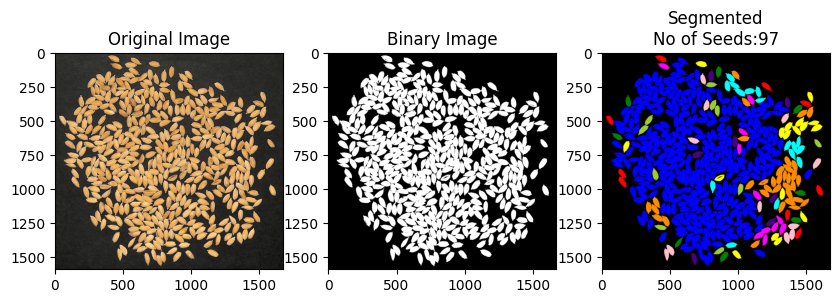

In [215]:
# 画像の読み込み
image = cv2.imread("/content/drive/MyDrive/phenotyping_temp_assets/rice.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 大津法による閾値の算出と背景分離
gray = rgb2gray(image)
threshold = threshold_otsu(gray)

# 閾値以上の明るさを物体、それ以外を背景としてbinary化
binary = gray > threshold

# 領域ラベル変換
lbl_image = label(binary)

# Count Seeds
# 種子の数は　ユニークなラベル数値から背景（値が0）を１つ分引いたものに相当
seed_no = len(np.unique(lbl_image)) - 1

# Convert label image to RGB image。可視化用
segmented = label2rgb(lbl_image)


# Visualize the segmented regions
plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')

plt.subplot(133)
plt.imshow(segmented, cmap='nipy_spectral')
plt.title("Segmented\nNo of Seeds:"+str(seed_no))
plt.show()

上記の右側の画像が種子認識をした結果です。異なる色は、違う種子として認識できていることを表しています。446粒のうち、97領域しか単離できず、そのうえ、大部分は複数の種子の塊となっています。これではとても形状解析まで持ち込めません。なんらかの手法で種子の境界を認識し、分割する方法の導入が必要です。

そこで、さらに画像解析の分野でよく使われてきたWatershedアルゴリズムを導入します。

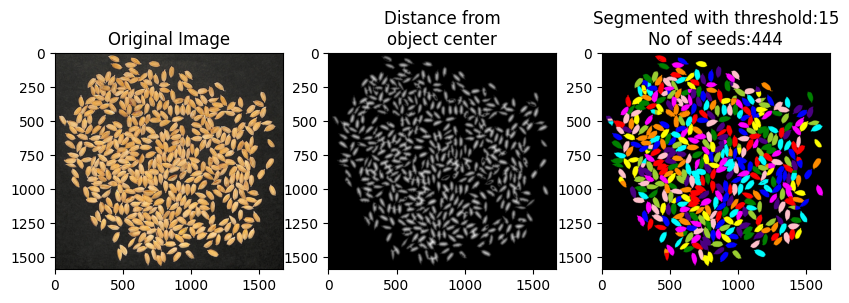

In [190]:
DISTANCE_THRESHOLD = 15

# 大津法にて背景分離を行います。
gray = rgb2gray(image)
threshold = threshold_otsu(gray)
binary = gray > threshold
# Distance transform to find markers for watershed
distance = ndi.distance_transform_edt(binary)
# Generate markers for the watershed
markers = label(distance > DISTANCE_THRESHOLD, connectivity=2)
# Apply watershed segmentation
lbl_image = watershed(-distance, markers, mask=binary)
# Convert label image to RGB image
segmented = label2rgb(lbl_image)

# Count Seeds
# 種子の数は　ユニークなラベル数値から背景（値が0）を１つ分引いたものに相当
seed_no = len(np.unique(lbl_image)) - 1

# Visualize the segmented regions
plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(distance, cmap='gray')
plt.title('Distance from\nobject center')

plt.subplot(133)
plt.imshow(segmented, cmap='nipy_spectral')
plt.title('Segmented with threshold:'+ str(DISTANCE_THRESHOLD) + "\nNo of seeds:"+str(seed_no))
plt.show()

かなりの改善が見られました。DISTANCE_THRESHOLDの閾値を手動で変えてみることで、結果の変化が確認できます。
ただ、手動で値を変更し、最適な値を探索するのは大変です。0-30の間で検出可能な種子の数がどう変化するか自動探索してみましょう。


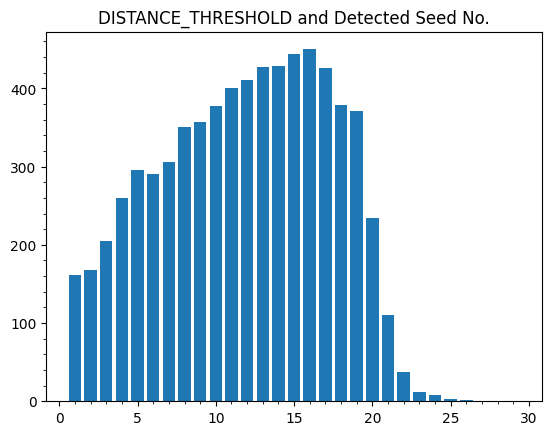

In [216]:
def get_seed_no_from_watershed(image, distance_threshold = 15):
    # 大津法にて背景分離を行います。
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    # Distance transform to find markers for watershed
    distance = ndi.distance_transform_edt(binary)
    # Generate markers for the watershed
    markers = label(distance > distance_threshold, connectivity=2)
    # Apply watershed segmentation
    lbl_image = watershed(-distance, markers, mask=binary)
    # Convert label image to RGB image
    segmented = label2rgb(lbl_image)
    seed_no = len(np.unique(lbl_image)) - 1
    return seed_no, lbl_image, segmented

result = []
for i in range(1,30):
    # 種子数のみ結果を集めます。画像は使いません
    seed_no, _, _ = get_seed_no_from_watershed(image, distance_threshold=i)
    result.append([i,seed_no])

result = np.array(result)

plt.title("DISTANCE_THRESHOLD and Detected Seed No.")
plt.bar(result[:,0],result[:,1])

# 補助メモリ線の表示
plt.minorticks_on()

値が14~16のときに最も多くの領域を検出できていそうです。

**ただし、この値は検出された領域の総数であって、真の種子数と同義ではないことに注意しましょう。**
得られた値は、過分割された種子も含まれますし、一方では、検出されなくなった種子も含まれません。

Text(0.5, 1.0, 'No of Seeds:429')

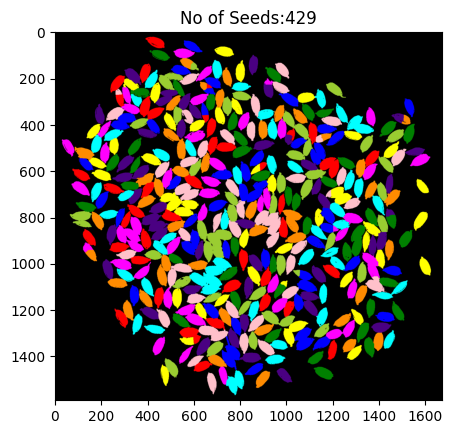

In [234]:
seed_no, lbl_image, segmented_image = get_seed_no_from_watershed(image, distance_threshold=14)
# Visualize the segmented regions
plt.figure(figsize=(5, 5))
plt.imshow(segmented_image, cmap='nipy_spectral')
plt.title("No of Seeds:"+str(seed_no))

この方法で単離された領域をもとに形状測定を行いましょう。

In [239]:
# 形状解析
# props = regionprops(lbl_image)
# 今回はみやすさのため、regionprops_tableを使います。

result_dict = regionprops_table(lbl_image, properties=["area","axis_major_length","axis_minor_length", "eccentricity","bbox","image"])
df = pd.DataFrame(result_dict)
df

,area,axis_major_length,axis_minor_length,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image
0,2646,85.254134,41.015213,0.876669,25,390,75,473,"[[False, False, False, False, False, False, Fa..."
1,2287,86.543921,34.237429,0.918420,40,556,92,636,"[[False, False, False, True, True, False, Fals..."
2,2628,81.148629,41.565586,0.858857,67,688,111,773,"[[False, False, False, False, False, False, Fa..."
3,2702,85.554114,40.703408,0.879574,75,511,117,603,"[[False, False, False, False, False, False, Fa..."
4,2458,85.043518,37.942916,0.894954,82,408,129,496,"[[False, False, False, False, False, False, Fa..."
...,...,...,...,...,...,...,...,...,...
424,2949,87.171223,43.312656,0.867826,1447,1116,1502,1201,"[[False, False, False, False, False, False, Fa..."
425,2378,79.325459,38.784165,0.872326,1452,956,1515,1024,"[[False, False, False, False, False, False, Fa..."
426,2735,86.139815,40.850644,0.880397,1464,867,1538,929,"[[False, False, False, False, False, False, Fa..."
427,4845,94.704422,71.343601,0.657644,1461,737,1569,816,"[[False, False, False, False, False, False, Fa..."


<Axes: xlabel='Count', ylabel='axis_major_length'>

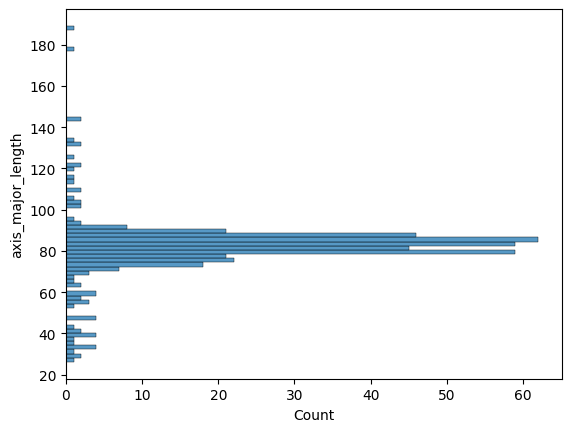

In [237]:
# 長軸長（px）の分布をみてみます。
sns.histplot(data=df, y="axis_major_length")
plt.show()

In [241]:
# Pandasデータフレームに含まれる検出ノイズを除去するために、四分位範囲（Interquartile Range, IQR）を使用してフィルタリングすることができます。

# IQRを計算する
Q1 = df['axis_major_length'].quantile(0.25)
Q3 = df['axis_major_length'].quantile(0.75)
IQR = Q3 - Q1

# 下限と上限を計算する
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 下限より小さい値または上限より大きい値を持つ行を削除する
filtered_df = df[(df['axis_major_length'] >= lower_bound) & (df['axis_major_length'] <= upper_bound)]

# フィルタリング後のデータを表示
filtered_df

,area,axis_major_length,axis_minor_length,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image
0,2646,85.254134,41.015213,0.876669,25,390,75,473,"[[False, False, False, False, False, False, Fa..."
1,2287,86.543921,34.237429,0.918420,40,556,92,636,"[[False, False, False, True, True, False, Fals..."
2,2628,81.148629,41.565586,0.858857,67,688,111,773,"[[False, False, False, False, False, False, Fa..."
3,2702,85.554114,40.703408,0.879574,75,511,117,603,"[[False, False, False, False, False, False, Fa..."
4,2458,85.043518,37.942916,0.894954,82,408,129,496,"[[False, False, False, False, False, False, Fa..."
...,...,...,...,...,...,...,...,...,...
424,2949,87.171223,43.312656,0.867826,1447,1116,1502,1201,"[[False, False, False, False, False, False, Fa..."
425,2378,79.325459,38.784165,0.872326,1452,956,1515,1024,"[[False, False, False, False, False, False, Fa..."
426,2735,86.139815,40.850644,0.880397,1464,867,1538,929,"[[False, False, False, False, False, False, Fa..."
427,4845,94.704422,71.343601,0.657644,1461,737,1569,816,"[[False, False, False, False, False, False, Fa..."


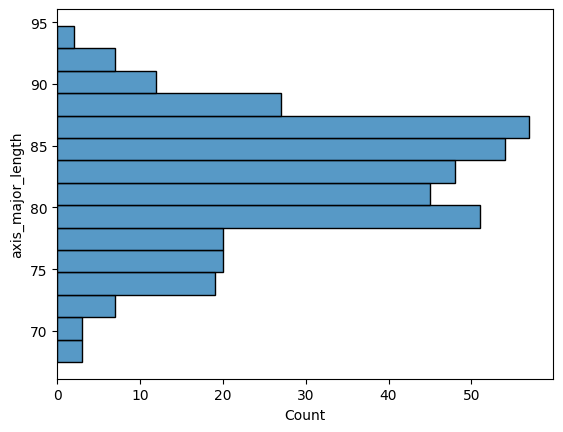

In [242]:
# 長軸長（px）の分布をみてみます。
sns.histplot(data=filtered_df, y="axis_major_length")
plt.show()
# だいぶすっきりしました。

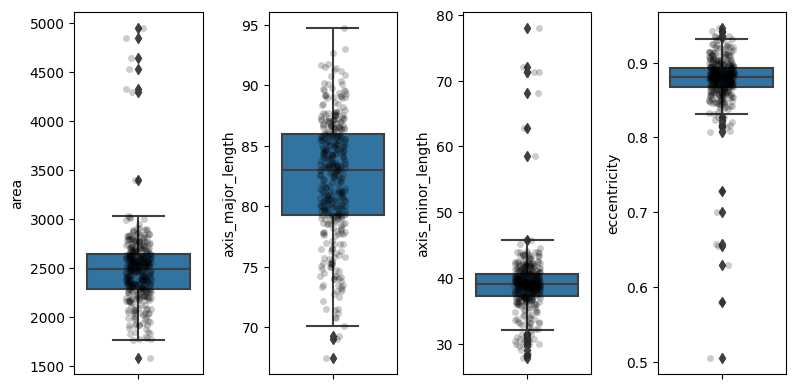

In [255]:
# area, axis_major_length, axis_minor_length, eccentricityの項目について描画します。
plt.figure(figsize=(10,4))
phenotype = ["area", "axis_major_length", "axis_minor_length", "eccentricity"]
for i, pheno in enumerate(phenotype):
    plt.subplot(1,len(phenotype)+1,i+1)
    sns.boxplot(filtered_df, y=pheno)
    sns.stripplot(filtered_df, y=pheno, c="black", alpha=0.2, jitter=True)
plt.tight_layout()
